In [2]:
import YOLOtrack11
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageFile
from YOLOtrack11.results import ZAxisResults as Results
import PIL
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle
from importlib import reload
# from ultralytics.utils.metrics import box_iou
from scipy.optimize import linear_sum_assignment
import torch
from ultralytics.utils import ops
from itertools import repeat

def plot_gt(path,ax):
    data=np.atleast_2d(np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt"))).T
    # print(data)
    if(len(data)==0):
         return plot_result(ax,path, np.empty(0),np.empty((0,4)),np.empty(0),np.empty((0,0)))
    cls = data[0]
    bboxes = data[1:5].T
    z = data[5]
    kpts = data[6:].T*512
    # print(bboxes)
    
    return plot_result(ax,path, cls,bboxes,z,kpts)
def plot_gt_yundon(idx,ax,img_num=0):
    imgpaths = ["BGC101_H2V2Z1_Ch1_zstack_1_MMStack_Pos0.ome.tif","BGC101_H2V2Z1_Ch1_zstack_1_MMStack_Pos0_1.ome.tif","BGC101_H2V2Z1_Ch1_zstack_1_MMStack_Pos0_2.ome.tif","BGC101_H2V2Z1_Ch1_zstack_1_MMStack_Pos0_3.ome.tif",]
    imgpath = imgpaths[img_num]
    img=PIL.Image.open("../../Pictures/"+imgpath)
    if idx > tiflen(img): #proceed to next image file
        return plot_gt_yundon(idx-tiflen(img),ax,img_num+1)
    img.seek(idx)
    x,y,z=np.loadtxt("../../Pictures/TrackingResultBugs_4th_TrackingGroundTruthScript250213.csv", delimiter=",").T
    x/=0.325
    y/=0.325
    z-=idx*1.338*0.2 # relative z in microns
    z+=761*210/1568#shift focus
    bx=by = (np.abs(z)*0.21+55)*0.8
    bboxes = np.array([x,y,bx,by]).T
    z/=210 # convert to network scale
    mask = (z > 0)&( z < 1)
    # if(len(data)==0):
    #      return plot_result(ax,path, np.empty(0),np.empty((0,4)),np.empty(0),np.empty((0,0)))
    cls = np.zeros_like(x)
    
    kpts = np.array([x,y]).T
    # print(bboxes)
    
    return plot_result(ax,img, cls[mask],bboxes=bboxes[mask],z=z[mask],kpts=kpts[mask],imgsz=1)

def tiflen(img):
    i=0
    while True:
        try:
            img.seek(i)
        except EOFError:
            return i
        i+=1
     
def plot_result(ax,img,cls,bboxes=repeat(None),z=None,kpts=None, conf=None, imgsz=512):
    is_conf = conf is not None
    if not is_conf:
         conf = np.zeros_like(cls)
    if isinstance(img, PIL.Image.Image):
        pass
    elif(type(img) == str):
        img = PIL.Image.open(img)
    ax.imshow(img,cmap="grey",vmin=1.95e4,vmax=2.05e4)
    ax.axis("off")

    for bbox,z_value,kpt,c in zip(bboxes,z,kpts,conf):
        if(bbox is not None):
            x,y,w,h = bbox*imgsz
            rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
            tx,ty = rect.get_xy()
            ax.add_patch(rect)
            tx+=6
            ty-=12
        else:
            tx,ty = kpt
            ty-=40
            tx-=50
        circle = Circle(kpt,1, facecolor="red",edgecolor="red")
        ax.add_patch(circle)
        ax.text(tx,ty,f"z={z_value:.3f}" + (f", {c*100:.0f}%" if is_conf else ""),fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))

    return bboxes,z

      
def match_predictions(pred_bboxes, gt_bboxes, pred_classes, true_classes,threshold):

        iou = box_iou(torch.Tensor(gt_bboxes), torch.Tensor(pred_bboxes))

        correct = np.zeros((pred_classes.shape[0])).astype(bool)
        gt_pred_matches = np.zeros((true_classes.shape[0],pred_classes.shape[0] ), dtype=bool)
        # LxD matrix where L - labels (rows), D - detections (columns)
        correct_class = true_classes[:, None] == pred_classes
        iou = iou * correct_class  # zero out the wrong classes
        iou = iou.cpu().numpy()

        cost_matrix = iou * (iou >= threshold)
        if cost_matrix.any():
            labels_idx, detections_idx = linear_sum_assignment(cost_matrix, maximize=True)
            valid = cost_matrix[labels_idx, detections_idx] > 0
            if valid.any():
                correct[detections_idx[valid]] = True
                gt_pred_matches[labels_idx,detections_idx] = valid

        return correct, gt_pred_matches
def box_iou(box1, box2, eps=1e-7):

    (a1, a2), (b1, b2) = box1.float().unsqueeze(1).chunk(2, 2), box2.float().unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

In [6]:
# reload(results)
model = YOLOtrack11.YOLOtrack11("../ultralytics/runs/pose/train62/weights/last.pt")
# print(model.model.model)
print("loaded")
dataset_path = "../ultralytics/data_gen/Dataset/images/test"
test_images = os.listdir(dataset_path)
random_image = lambda: dataset_path+"/"+test_images[np.random.randint(0,len(test_images))]



loaded


In [19]:
reload(YOLOtrack11)
# %matplotlib 
if not plt.get_fignums() : plt.figure(figsize=(12,5))
else: plt.clf()
# image = random_image()
image = random_image()
img = np.array(PIL.Image.open(image))#-12768
img = img[:856,:856]
print(img.shape)
results = model.predict(img, conf = 0.75)
res = results[0].zaxis.data.cpu().numpy()
# kpts = results[0].keypoints.data.cpu().numpy()
# print(res)
plt.subplot(1,2,1)
plt.title("Prediction")
plot_result(plt.gca(),image,res[:,4],ops.xyxy2xywh(res[:,:4])/512,res[:,6],res[:,7:],conf=res[:,4])
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Ground Truth")
# ops.scale_boxes((512,512), gt_bbox, ori_shape, ratio_pad=ratio_pad)  # native-space labels
gt_bboxes,gt_z_values = plot_gt(image,plt.gca())
gt_z_values*=210
true_bboxes = ops.xywh2xyxy(gt_bboxes) * np.array((512,512))[[1, 0, 1, 0]]  # target boxes
_, gt_pred_matcher = match_predictions(res[:,:4],true_bboxes,np.zeros(len(res)),np.zeros(len(true_bboxes)),0.5)
print("gt  :", gt_z_values[np.where(gt_pred_matcher.T)[1]])
print("yolo:", res[:,-1])
# print("corr:", np.array(corr))
print("gt undetected:", gt_z_values[np.where(gt_pred_matcher.sum(1)==0)[0]])

plt.show()



NameError: name 'random_image' is not defined

<Figure size 1200x500 with 0 Axes>

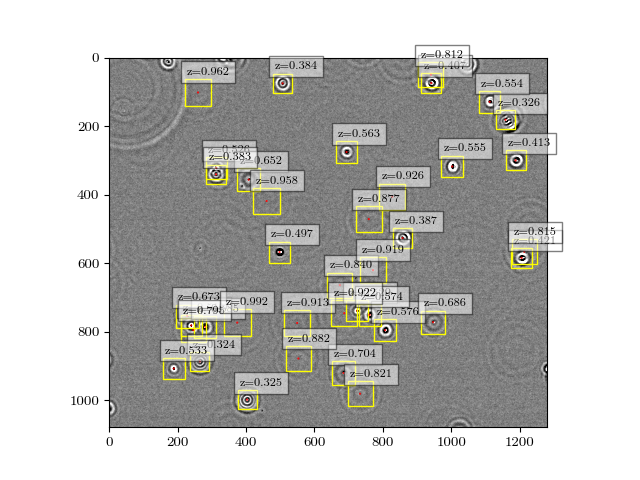

In [39]:
plt.clf()
i+=20
plot_gt_yundon(i,plt.gca())
plt.axis("on")
plt.show()


In [26]:
plt.xlim(),plt.ylim()

((np.float64(835.2792207792209), np.float64(1080.7337662337663)),
 (np.float64(1011.7077922077922), np.float64(830.5389610389609)))

In [28]:
img = PIL.Image.open("../../Pictures/BGC101_H2V2Z1_Ch1_zstack_1_MMStack_Pos0.ome.tif")
img.seek(100)

In [29]:
image = np.array(img)

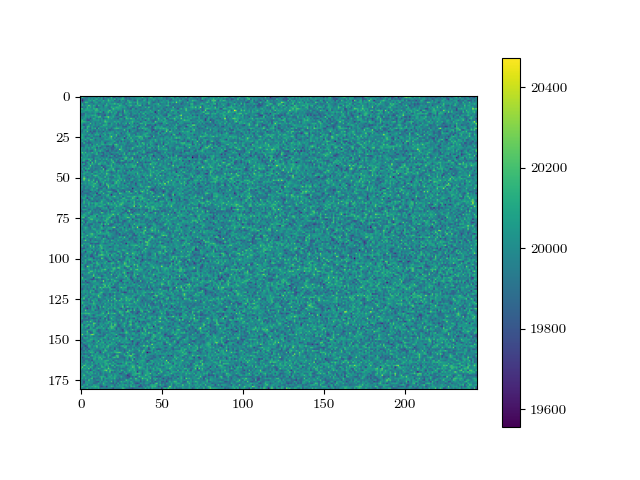

In [36]:
plt.clf()
background_sample = image[830:1011,835:1080]

plt.imshow(background_sample)
plt.colorbar()
plt.show()

In [38]:
background_sample.std(),(background_sample-2e4).std()

(np.float64(105.87939967872548), np.float64(105.87939967872548))

/tmp/ipykernel_3946792/1166659771.py:62: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  iou = iou * correct_class  # zero out the wrong classes
/tmp/ipykernel_3946792/497207010.py:44: RuntimeWarning: invalid value encountered in scalar divide
  return f/np.max(f)
/tmp/ipykernel_3946792/497207010.py:44: RuntimeWarning: invalid value encountered in scalar divide
  return f/np.max(f)
/tmp/ipykernel_3946792/497207010.py:44: RuntimeWarning: invalid value encountered in scalar divide
  return f/np.max(f)
/tmp/ipykernel_3946792/497207010.py:44: RuntimeWarning: invalid value encountered in scalar divide
  return f/np.max(f)
/tmp/ipykernel_3946792/497207010.py:44: RuntimeWarning: invalid value encountered in scalar divide
  return f/np.max(f)
/tmp/ipykernel_3946792/497207010.py:44: RuntimeWarning: invalid value encountered in scalar divide
  return f/np.max(f)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 2000x1000 with 0 Axes>

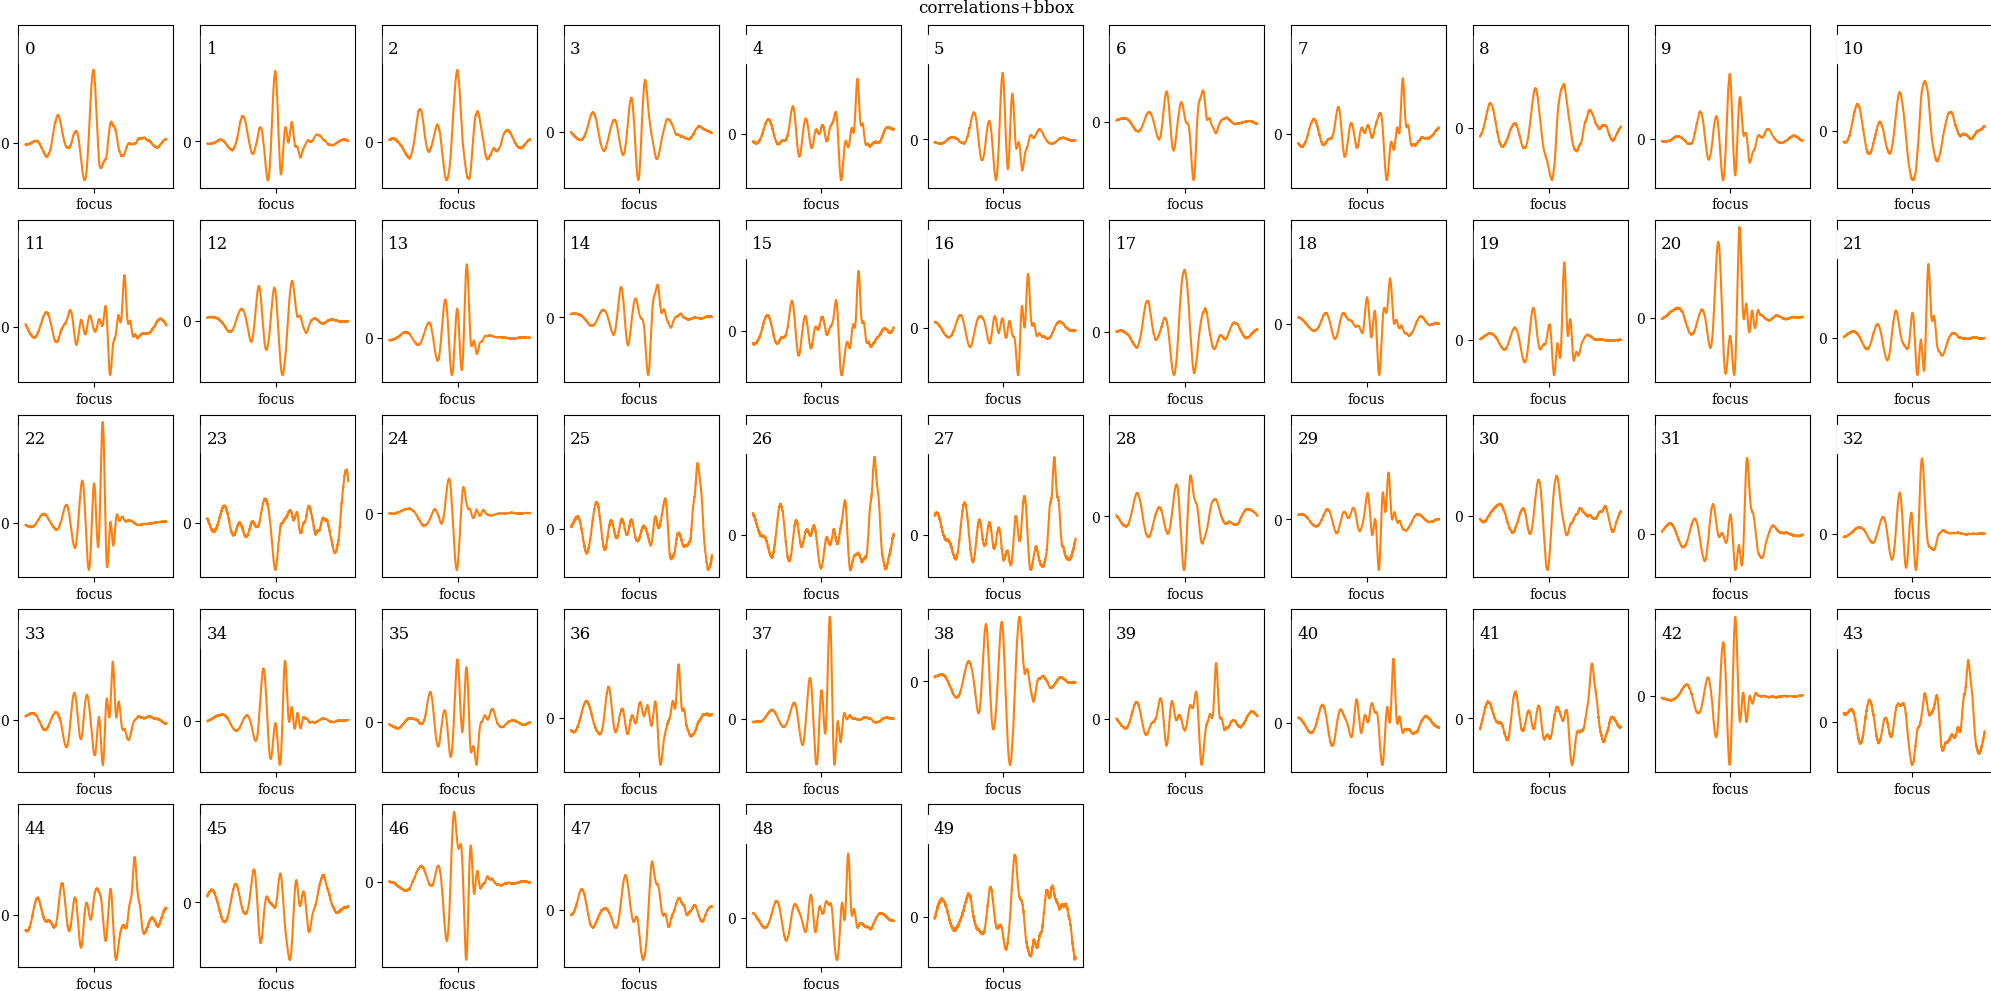

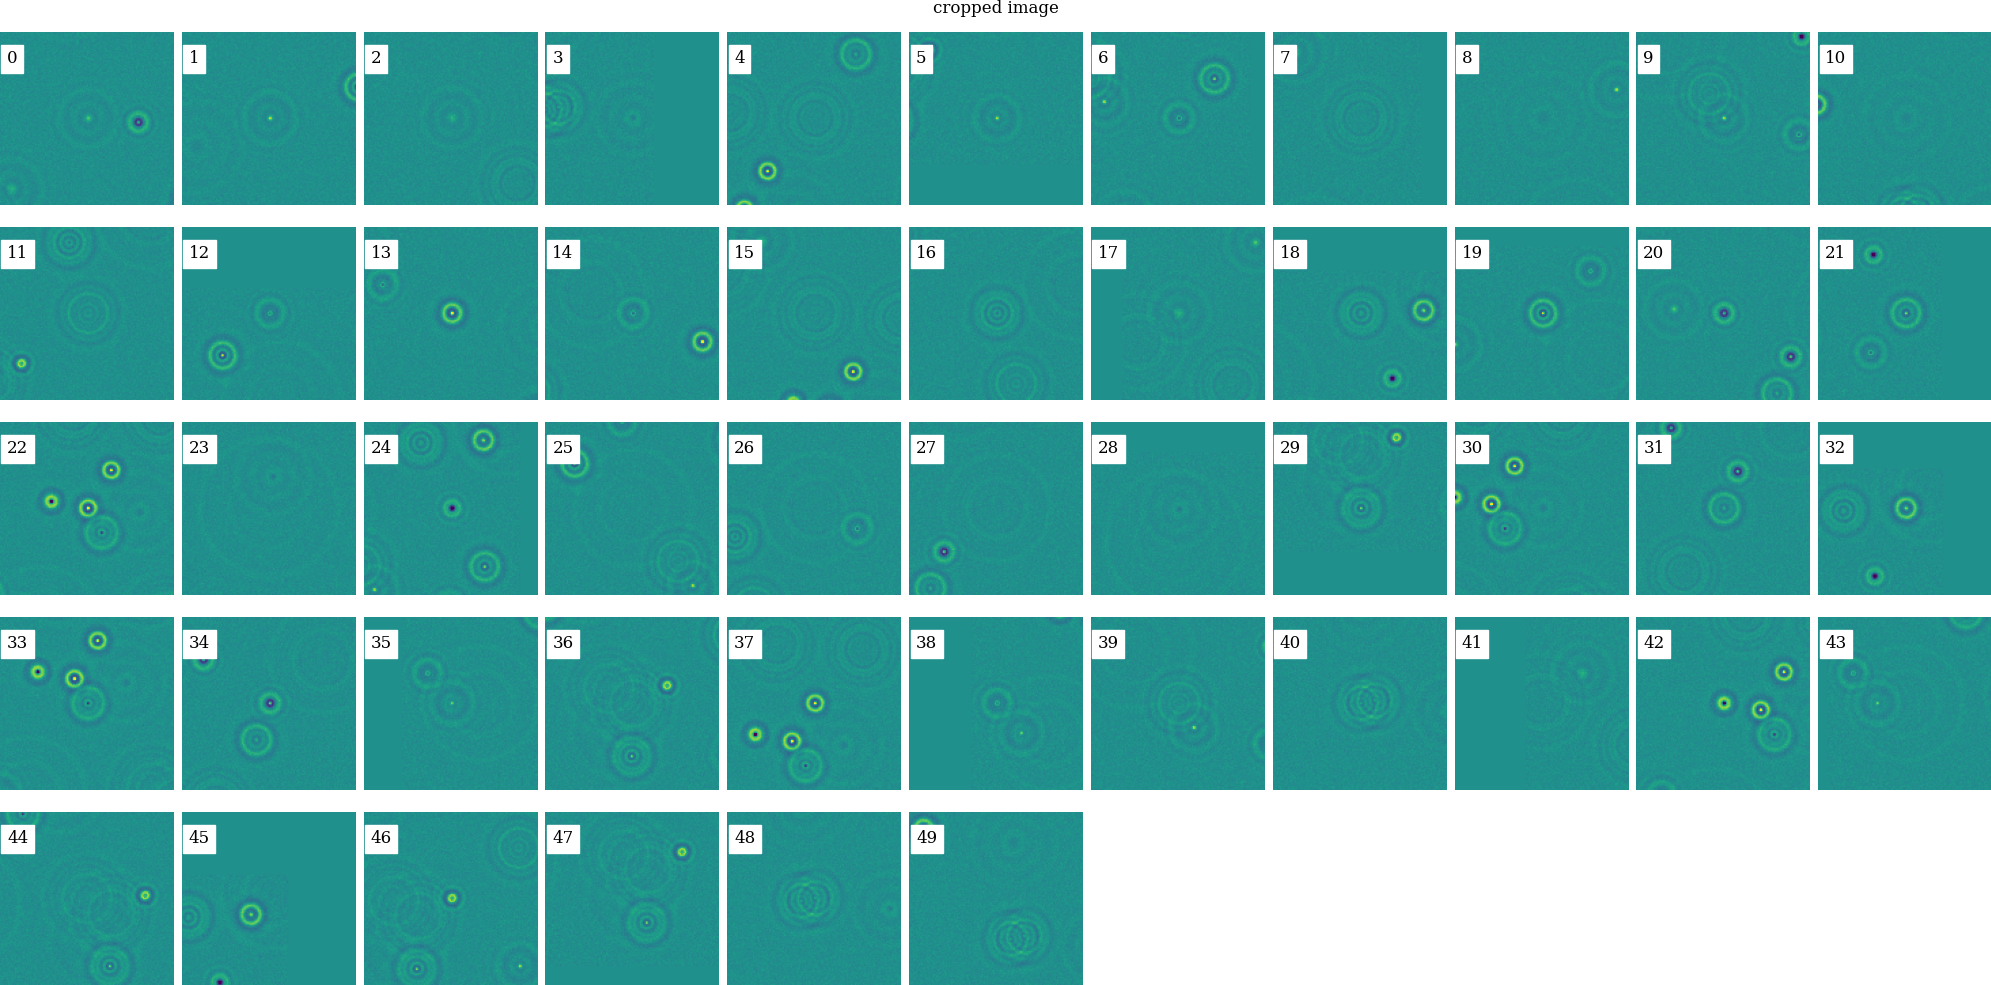

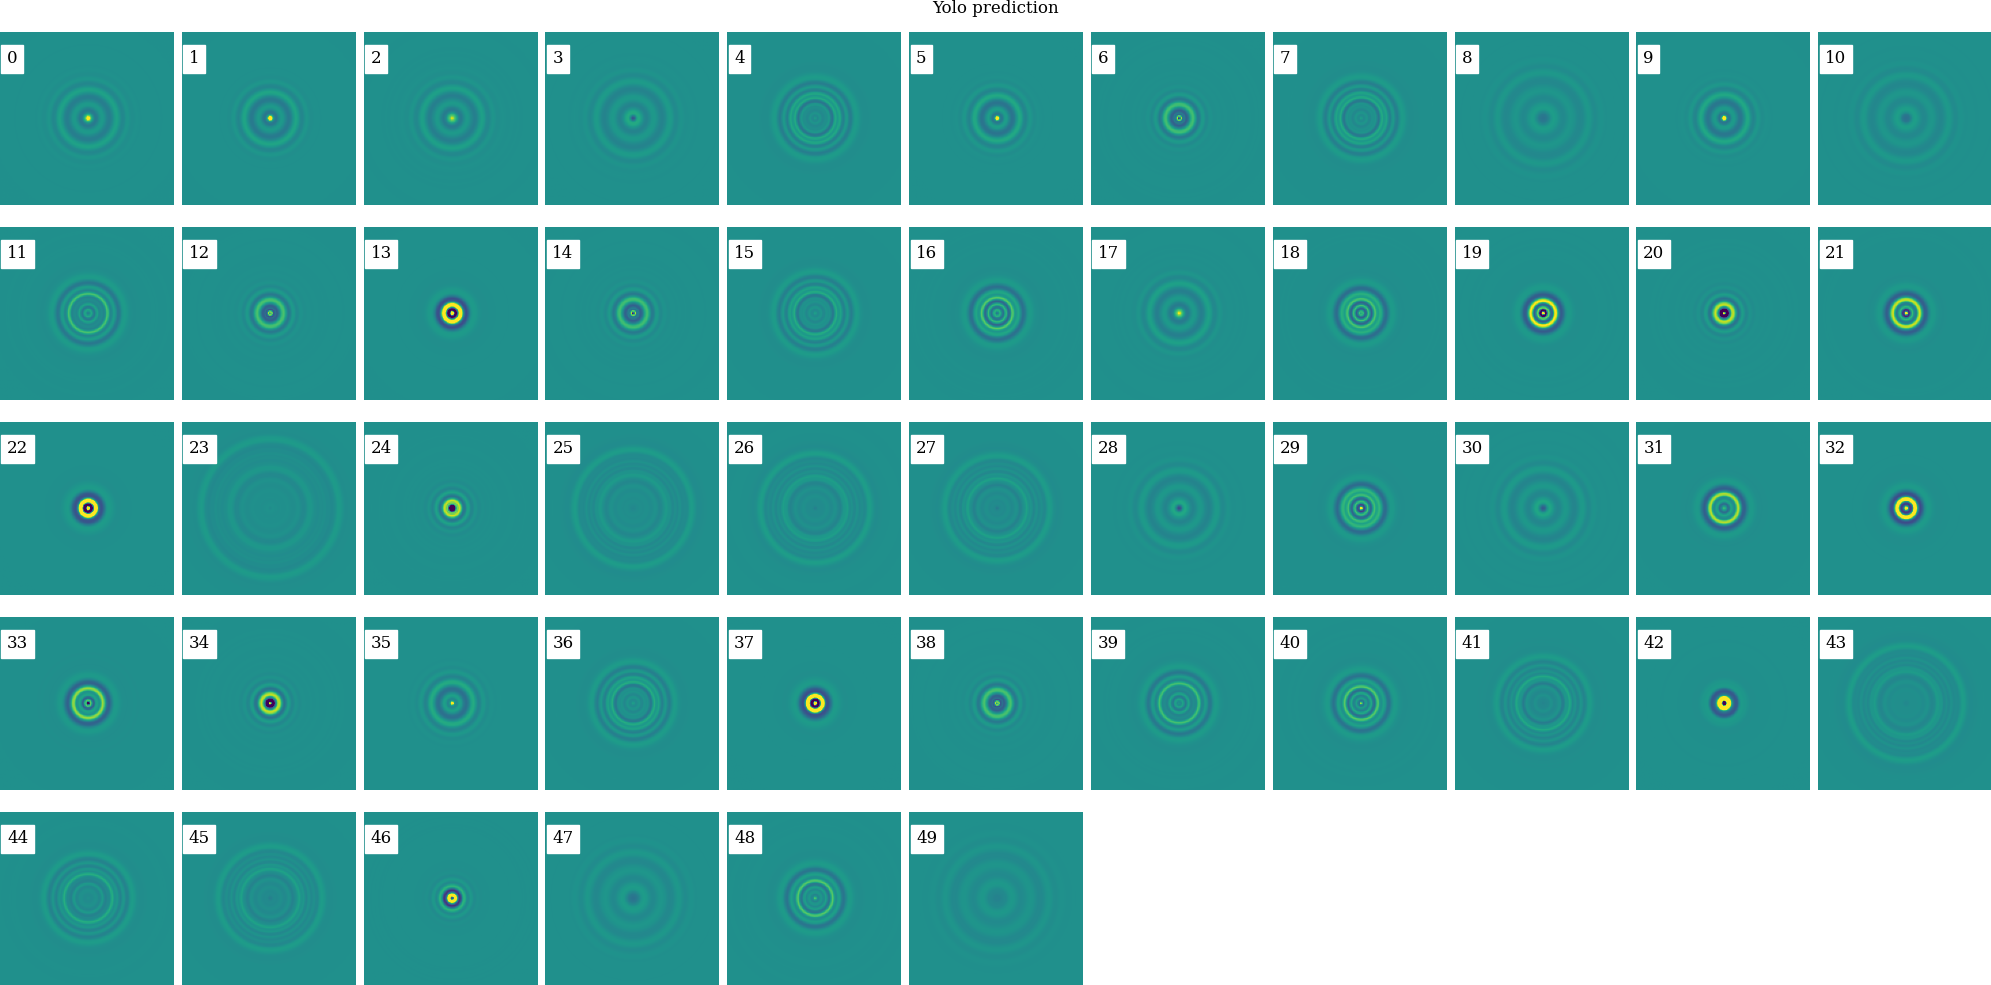

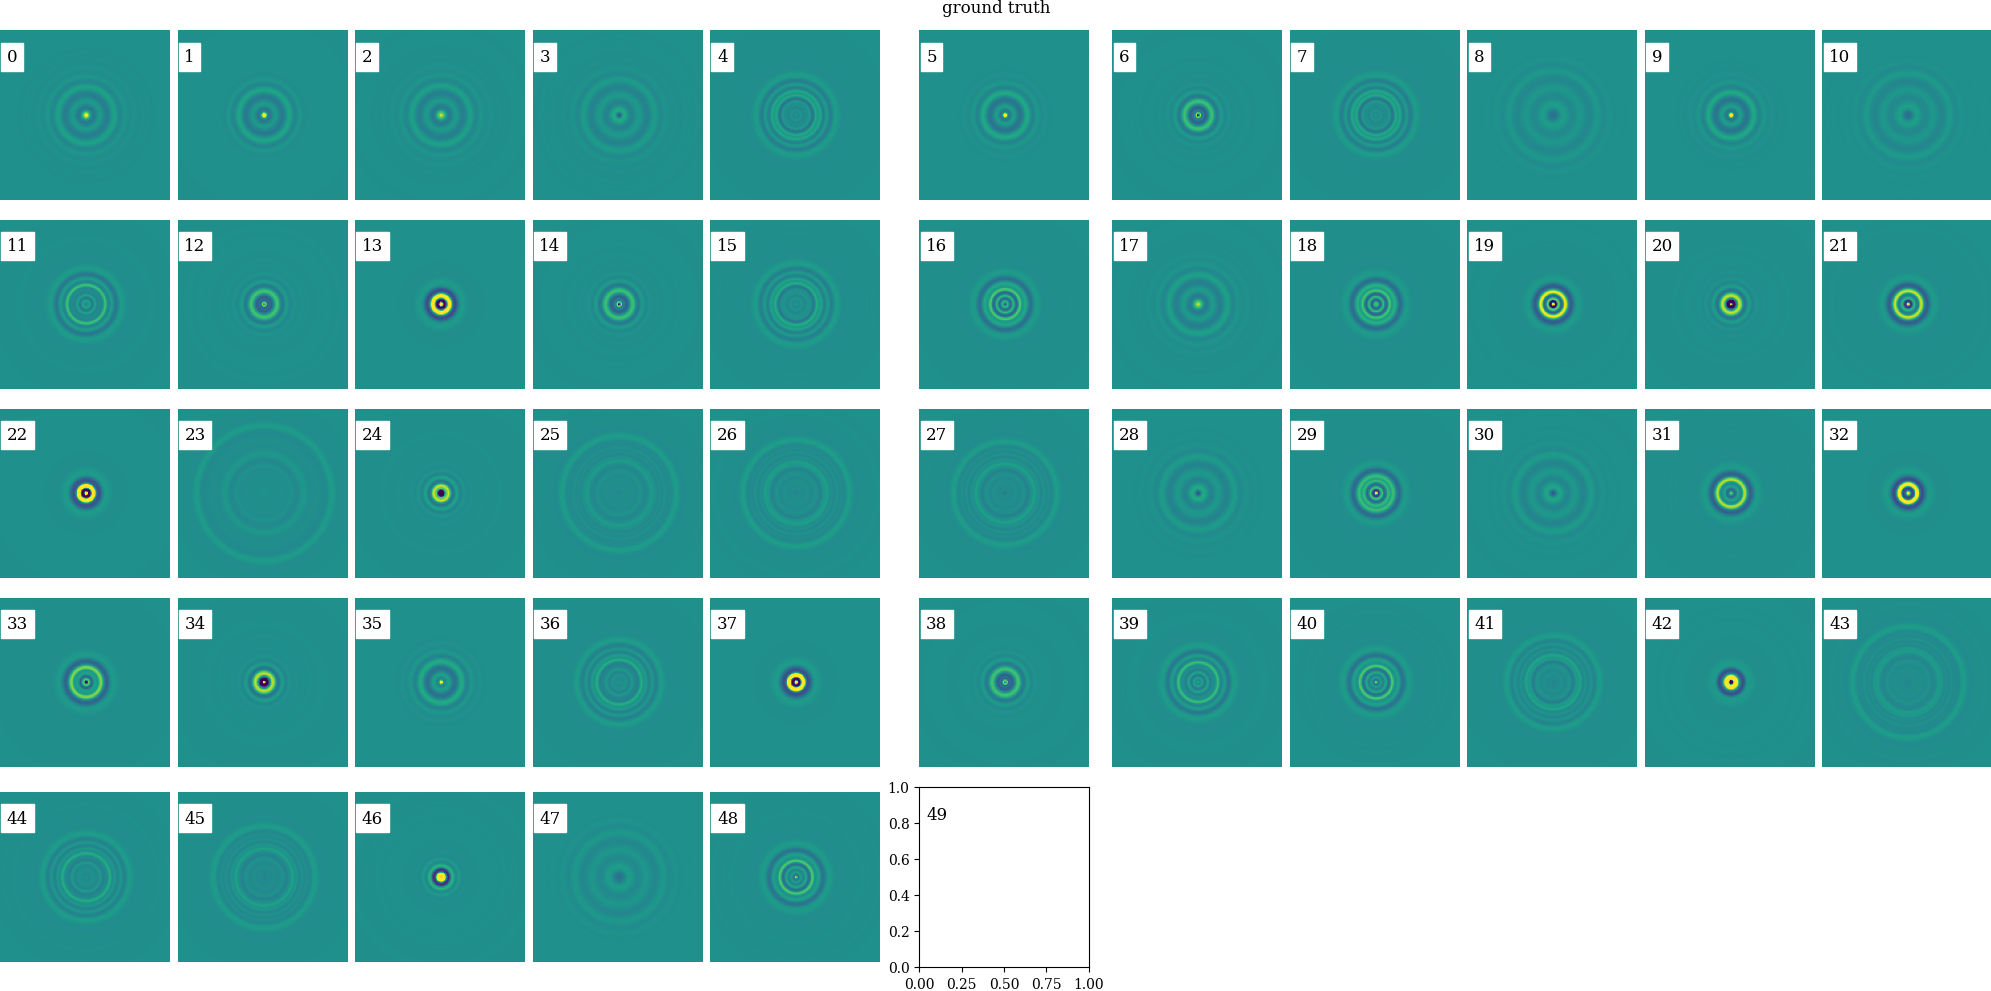

In [5]:
# plt.figure()
# plt.imshow(results[0].orig_img)
# plt.figure(figsize=(20,2))

padding=128
size=128
padded_image = np.pad(results[0].orig_img,padding,mode="constant",constant_values=2e4)

# plt.axis("off")
captures = np.empty((len(res),size,size))
for i,box in enumerate(res):
    # print(box)
    x1,y1,x2,y2,_,_,z,x,y = box
    w,h = x2-x1,y2-y1
    if(x1 == 0):
        x1-=h-w
        w = h
    if(y1 == 0):
        y1-=w-h
        h = w
    if(x2 == 511):
        x2+=h-w
        w = h
    if(y2 == 511):
        y2+=w-h
        h = w
    x,y = 0.5*(x1+x2),0.5*(y1+y2)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    captures[i] = padded_image[y+padding-size//2:y+padding+size//2,x+padding-size//2:x+padding+size//2]
# captures/=
# captures-=1
downsampled_reference = (np.load("../ultralytics/data_gen/ripples_downsampled.npy")/10000)-2
true_bboxes = ops.xywh2xyxy(gt_bboxes) * np.array((512,512))[[1, 0, 1, 0]]  # target boxes
# ops.scale_boxes((512,512), gt_bbox, ori_shape, ratio_pad=ratio_pad)  # native-space labels
_, gt_pred_matcher = match_predictions(res[:,:4],true_bboxes,np.zeros(len(res)),np.zeros(len(true_bboxes)),0.5)
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
plt.figure(figsize=(20,2*len(captures)//11+1))
def bells(x,w,*args):
    f = np.sum([np.exp(-(w*(x-mu)**2)) for mu in args],axis=0)
    return f/np.max(f)
x = np.arange(len(downsampled_reference))
corr = []
for i,capture in enumerate(captures):

    x1,y1,x2,y2,_,_,pred_z,x,y = res[i]
    w,h = x2-x1,y2-y1
    v = (max(w,h)*(2)-55)
    z  = (-v/0.21)+761,(v/0.21)+761
    plt.figure(1)
    plt.suptitle("correlations+bbox")
    correlation = np.pow((downsampled_reference*(capture/10000-2)).sum(axis=(1,2)),1)
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.plot(bells(x,5e-4,*z)*(np.max(correlation)-np.min(correlation)))
    plt.plot(correlation)
    # plt.axvline(pred_z*len(downsampled_reference), c="red")
    plt.xticks([761],["focus"])
    plt.yticks([0])
    # plt.ylim(0,0.5)c
    # plt.tight_layout()

    plt.figure(2)
    plt.suptitle("cropped image")
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.imshow(capture,vmin=1.85e4,vmax=2.15e4)
    plt.axis("off")
    # plt.tight_layout()
    plt.figure(3)
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    plt.suptitle("Yolo prediction")
    plt.imshow(downsampled_reference[np.round(pred_z*len(downsampled_reference)).astype(int)],vmin=-0.05,vmax=0.05)
    plt.axis("off")

    plt.figure(4)
    plt.suptitle("ground truth")
    plt.subplot(len(captures)//11+1,11,i+1)
    plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")

    correct_detection = np.where(gt_pred_matcher.T[i])[0]
    # if correct_detection:
    gt_image = (downsampled_reference[np.round(gt_z_values[correct_detection]*len(downsampled_reference)).astype(int)])
    # else:
    #     gt_image = np.zeros((1,128,128))
    plt.imshow(gt_image[0],vmin=-0.05,vmax=0.05)
    plt.axis("off")
    # plt.figure(4)
    # plt.suptitle("image via max correlations+bbox size")

    # plt.subplot(len(captures)//11+1,11,i+1)
    # plt.title(str(i), y=0.77,x=0.04,loc="left",backgroundcolor="white")
    # plt.imshow(downsampled_reference[np.argmax(correlation*bells(x,5e-4,*z))],vmin=-0.05,vmax=0.05)
    # corr.append(np.argmax(correlation*bells(x,5e-4,*z))/len(downsampled_reference))
    # plt.axis("off")



    # plt.colorbar()



In [7]:
undetected = downsampled_reference[np.round(gt_z_values[np.where(gt_pred_matcher.sum(1)==0)[0]]).astype(int)]
plt.figure(figsize=(20,2))
for i,img in enumerate(undetected):
    plt.subplot(1,11,i+1)
    plt.imshow(img)
plt.show()

<Figure size 2000x200 with 0 Axes>